In [8]:
# Ensure the parent 'backend' directory is on sys.path so 'core' package can be imported
from pathlib import Path
import sys
backend_dir = Path.cwd().parent  # .../backend
if str(backend_dir) not in sys.path:
    sys.path.insert(0, str(backend_dir))
print('sys.path configured for core package:', backend_dir)


sys.path configured for core package: c:\Users\user\OneDrive\Desktop\CODE\Dynamic-Personal-Finance-Agent\backend


In [3]:
from IPython.display import display, Image

In [9]:
"""
LangGraph-based Financial Planning Workflow
Implementation based on the provided workflow diagram
Follows standard Python naming conventions and best practices
"""

import asyncio
from typing import Dict, Any, List, Optional, TypedDict, Annotated
from dataclasses import dataclass, field
from enum import Enum
import operator
from langgraph.graph import StateGraph, END, START
from core.groq_client import groq_client


class WorkflowStage(Enum):
    """Workflow stages as defined in the diagram"""

    STARTED = "started"
    MVP = "mvp"
    INTERMEDIATE = "intermediate"
    ADVANCED = "advanced"


class FinanceState(TypedDict):
    """
    LangGraph state following the workflow diagram
    Using TypedDict for proper LangGraph integration
    """

    # Core user information
    user_id: str
    user_query: str

    # System state tracking
    current_stage: str
    system_stage: str

    # Intent and context
    intent: str
    context: Dict[str, Any]

    # Processing results
    response: str
    analysis_results: Dict[str, Any]
    next_action: str

    # Tool tracking
    tools_used: Annotated[List[str], operator.add]

    # Conversation history
    messages: Annotated[List[Dict[str, str]], operator.add]

    # Workflow control
    consent_given: bool
    profile_complete: bool
    execute_action: bool

    # Explainable AI trace
    explanations: Annotated[List[Dict[str, Any]], operator.add]


class FinancialPlanningWorkflow:
    """
    Complete LangGraph workflow implementation
    Based on the provided workflow diagram
    """

    def __init__(self):
        self.workflow = self._create_workflow()

    def _create_workflow(self) -> StateGraph:
        """Create the LangGraph workflow based on the diagram"""

        # Initialize workflow graph
        workflow = StateGraph(FinanceState)

        # Add all nodes from the diagram
        workflow.add_node("system_stage_router", self._system_stage_router)
        workflow.add_node("onboarding_node", self._onboarding_node)
        workflow.add_node("store_consent_profile", self._store_consent_profile)
        workflow.add_node("intent_classifier", self._intent_classifier)
        workflow.add_node("statement_parser", self._statement_parser)
        workflow.add_node("budget_analyzer", self._budget_analyzer)
        workflow.add_node("goal_planner", self._goal_planner)
        workflow.add_node("task_decomposer", self._task_decomposer)
        workflow.add_node("reasoning_engine", self._reasoning_engine)
        workflow.add_node("rag_knowledge_retriever", self._rag_knowledge_retriever)
        workflow.add_node("ml_models", self._ml_models)
        workflow.add_node("finance_tools", self._finance_tools)
        workflow.add_node("action_executor", self._action_executor)
        workflow.add_node("dashboard_generator", self._dashboard_generator)
        workflow.add_node("notification_sender", self._notification_sender)
        workflow.add_node("feedback_collector", self._feedback_collector)
        workflow.add_node("continuous_learning", self._continuous_learning)

        # Set entry point
        workflow.set_entry_point("system_stage_router")

        # Add edges based on the workflow diagram
        self._add_workflow_edges(workflow)

        return workflow.compile()

    def _add_workflow_edges(self, workflow: StateGraph):
        """Add edges based on the workflow diagram logic"""

        # System stage router - main decision point
        workflow.add_conditional_edges(
            "system_stage_router",
            self._route_by_stage,
            {
                "started": "onboarding_node",
                "mvp": "intent_classifier",
                "intermediate": "rag_knowledge_retriever",
                "advanced": "task_decomposer",
            },
        )

        # Started stage flow
        workflow.add_edge("onboarding_node", "store_consent_profile")
        workflow.add_edge("store_consent_profile", "intent_classifier")

        # MVP stage flow
        workflow.add_edge("intent_classifier", "statement_parser")
        workflow.add_edge("statement_parser", "budget_analyzer")
        workflow.add_edge("budget_analyzer", "goal_planner")
        workflow.add_edge("goal_planner", "dashboard_generator")

        # Intermediate stage flow
        workflow.add_edge("rag_knowledge_retriever", "reasoning_engine")
        workflow.add_edge("reasoning_engine", "finance_tools")
        workflow.add_edge("finance_tools", "notification_sender")

        # Advanced stage flow
        workflow.add_edge("task_decomposer", "reasoning_engine")
        workflow.add_edge("reasoning_engine", "ml_models")
        workflow.add_edge("ml_models", "action_executor")

        # Common endpoints
        workflow.add_conditional_edges(
            "action_executor",
            self._check_execution_decision,
            {
                "execute": "continuous_learning",
                "suggestions_only": "feedback_collector",
            },
        )

        # Terminal nodes
        workflow.add_edge("dashboard_generator", "feedback_collector")
        workflow.add_edge("notification_sender", "feedback_collector")
        workflow.add_edge("continuous_learning", END)
        workflow.add_edge("feedback_collector", END)

    async def run_async(self, state: FinanceState) -> FinanceState:
        """Run workflow asynchronously"""
        result = await self.workflow.ainvoke(state)
        return result

    def run_sync(self, state: FinanceState) -> FinanceState:
        """Run workflow synchronously"""
        result = self.workflow.invoke(state)
        return result

    async def stream_trace(self, state: FinanceState):
        """Yield workflow execution events as an async generator.
        Tries to use LangGraph astream_events; falls back to start/end only.
        Yields dicts like {"event": str, "data": {...}} suitable for SSE.
        """
        # Preferred: use LangGraph event stream if available
        try:
            astream_events = getattr(self.workflow, "astream_events", None)
            if astream_events is not None:
                async for evt in astream_events(state, version="v2"):
                    # evt is typically a dict with keys: 'event', 'data'
                    yield {"event": evt.get("event"), "data": evt.get("data", {})}
                return
        except Exception as _e:
            # Fall back to simple tracing
            pass

        # Fallback: emit start, then final state
        yield {"event": "start", "data": {"message": "Workflow started"}}
        try:
            final = await self.run_async(state)
            yield {"event": "end", "data": {"final_state": final}}
        except Exception as e:
            yield {"event": "error", "data": {"message": str(e)}}

    # Router functions
    def _route_by_stage(self, state: FinanceState) -> str:
        """Route based on current system stage"""
        return state.get("current_stage", "started")

    def _check_execution_decision(self, state: FinanceState) -> str:
        """Check if actions should be executed or just suggested"""
        return "execute" if state.get("execute_action", False) else "suggestions_only"

    # Node implementations
    async def _system_stage_router(self, state: FinanceState) -> FinanceState:
        """System stage router - main entry point"""
        state["tools_used"].append("system_stage_router")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "system_stage_router",
            "what": "Determine workflow stage based on consent and profile",
            "input": {
                "consent_given": state.get("consent_given"),
                "profile_complete": state.get("profile_complete"),
                "context": state.get("context", {})
            }
        })

        # Determine stage based on user profile and history
        if not state.get("consent_given", False):
            state["current_stage"] = WorkflowStage.STARTED.value
        elif not state.get("profile_complete", False):
            state["current_stage"] = WorkflowStage.MVP.value
        else:
            # Use advanced stage determination logic
            user_context = state.get("context", {})
            experience_level = user_context.get("experience_level", "beginner")

            if experience_level == "advanced":
                state["current_stage"] = WorkflowStage.ADVANCED.value
            elif experience_level == "intermediate":
                state["current_stage"] = WorkflowStage.INTERMEDIATE.value
            else:
                state["current_stage"] = WorkflowStage.MVP.value

        return state

    async def _onboarding_node(self, state: FinanceState) -> FinanceState:
        """Handle user onboarding, goals, consent, and profile setup"""
        state["tools_used"].append("onboarding_node")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "onboarding_node",
            "what": "Analyze onboarding requirements and prepare profile fields",
            "input": {"user_query": state.get("user_query")}
        })

        # Use Groq to analyze onboarding needs
        onboarding_prompt = f"""
        Analyze this user query for onboarding needs: {state['user_query']}
        
        Determine:
        1. What information is needed for their profile
        2. What consent/permissions are required
        3. What initial goals they want to set
        
        Provide structured guidance for onboarding.
        """

        result = await groq_client.chat(onboarding_prompt)

        state["analysis_results"]["onboarding"] = {
            "guidance": result,
            "profile_fields_needed": ["income", "expenses", "goals", "risk_tolerance"],
            "consent_required": [
                "data_processing",
                "financial_analysis",
                "goal_tracking",
            ],
        }

        return state

    async def _store_consent_profile(self, state: FinanceState) -> FinanceState:
        """Store user consent and minimal profile information"""
        state["tools_used"].append("store_consent_profile")

        # Mark consent as given and profile as started
        state["consent_given"] = True
        state["analysis_results"]["profile_status"] = "consent_stored"

        return state

    async def _intent_classifier(self, state: FinanceState) -> FinanceState:
        """Rule-based intent classification"""
        state["tools_used"].append("intent_classifier")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "intent_classifier",
            "what": "Classify the user's intent using Groq + heuristics",
            "input": {"user_query": state.get("user_query")}
        })

        # Use Groq for intent classification
        result = await groq_client.analyze_financial_query(
            state["user_query"], state.get("context", {})
        )

        state["intent"] = result["intent"]
        state["analysis_results"]["intent_analysis"] = result

        return state

    async def _statement_parser(self, state: FinanceState) -> FinanceState:
        """Parse CSV/PDF financial statements"""
        state["tools_used"].append("statement_parser")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "statement_parser",
            "what": "Parse statements (placeholder until uploads supported)",
        })

        # Simulate statement parsing
        state["analysis_results"]["parsed_statements"] = {
            "transactions_found": 0,
            "categories_identified": [],
            "date_range": "No statements uploaded",
            "parsing_status": "ready_for_upload",
        }

        return state

    async def _budget_analyzer(self, state: FinanceState) -> FinanceState:
        """Categorize and compute budget analysis"""
        state["tools_used"].append("budget_analyzer")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "budget_analyzer",
            "what": "Generate budget insights based on query and context",
            "input": {
                "intent": state.get("intent"),
                "context": state.get("context", {})
            }
        })

        # Use Groq for budget analysis
        budget_prompt = f"""
        Analyze this financial query for budget insights: {state['user_query']}
        Intent: {state.get('intent', 'unknown')}
        
        Provide budget recommendations and categorization advice.
        """

        result = await groq_client.chat(budget_prompt)

        state["analysis_results"]["budget_analysis"] = {
            "recommendations": result,
            "categories": [
                "Housing",
                "Transportation",
                "Food",
                "Entertainment",
                "Savings",
            ],
            "allocation_suggestions": "50/30/20 rule recommended",
        }

        return state

    async def _goal_planner(self, state: FinanceState) -> FinanceState:
        """Simple interest calculations and goal planning"""
        state["tools_used"].append("goal_planner")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "goal_planner",
            "what": "Suggest goals and timelines",
        })

        # Goal planning analysis
        state["analysis_results"]["goal_planning"] = {
            "suggested_goals": ["Emergency Fund", "Retirement", "Vacation"],
            "timeline_recommendations": "Short, medium, and long-term goals",
            "calculation_method": "Simple interest with inflation adjustment",
        }

        return state

    async def _task_decomposer(self, state: FinanceState) -> FinanceState:
        """Multi-step plan decomposition for advanced users"""
        state["tools_used"].append("task_decomposer")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "task_decomposer",
            "what": "Decompose complex request into actionable steps",
        })

        # Advanced task decomposition
        decomp_prompt = f"""
        Break down this complex financial request into actionable steps: {state['user_query']}
        
        Create a multi-step plan with priorities, timelines, and dependencies.
        """

        result = await groq_client.chat(decomp_prompt)

        state["analysis_results"]["task_decomposition"] = {
            "plan": result,
            "steps": ["Analysis", "Strategy", "Implementation", "Monitoring"],
            "complexity": "advanced",
        }

        return state

    async def _reasoning_engine(self, state: FinanceState) -> FinanceState:
        """LLM + Symbolic + RAG reasoning for intermediate/advanced stages"""
        state["tools_used"].append("reasoning_engine")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "reasoning_engine",
            "what": "Apply advanced reasoning to synthesize recommendations",
            "input": {
                "intent": state.get("intent"),
                "stage": state.get("current_stage")
            }
        })

        # Advanced reasoning using Groq
        reasoning_prompt = f"""
        Apply advanced financial reasoning to: {state['user_query']}
        
        Context: {state.get('context', {})}
        Intent: {state.get('intent', 'unknown')}
        Stage: {state.get('current_stage', 'unknown')}
        
        Provide comprehensive analysis combining:
        1. Quantitative financial analysis
        2. Risk assessment
        3. Market considerations
        4. Personalized recommendations
        """

        result = await groq_client.chat(reasoning_prompt)

        state["analysis_results"]["advanced_reasoning"] = {
            "analysis": result,
            "reasoning_type": "llm_symbolic_rag",
            "confidence": "high",
        }

        return state

    async def _rag_knowledge_retriever(self, state: FinanceState) -> FinanceState:
        """RAG knowledge retrieval for tax docs and FAQs"""
        state["tools_used"].append("rag_knowledge_retriever")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "rag_knowledge_retriever",
            "what": "Retrieve relevant knowledge for the topic",
        })

        # Simulate RAG knowledge retrieval
        state["analysis_results"]["knowledge_base"] = {
            "relevant_docs": [
                "Tax Guidelines 2025",
                "Investment FAQ",
                "Budget Planning Guide",
            ],
            "confidence_score": 0.85,
            "sources": "tax_docs_and_faqs",
        }

        return state

    async def _ml_models(self, state: FinanceState) -> FinanceState:
        """ML models for advanced financial analysis"""
        state["tools_used"].append("ml_models")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "ml_models",
            "what": "Run forecasting and optimization models",
        })

        # Advanced ML analysis
        state["analysis_results"]["ml_analysis"] = {
            "expense_forecast": "Projected 5% increase next quarter",
            "portfolio_optimization": "Rebalancing recommended",
            "risk_assessment": "Moderate risk profile",
            "model_confidence": 0.87,
        }

        return state

    async def _finance_tools(self, state: FinanceState) -> FinanceState:
        """Execute various financial tools"""
        state["tools_used"].append("finance_tools")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "finance_tools",
            "what": "Use tools based on intent",
            "input": {"intent": state.get("intent")}
        })

        # Determine which tools to use based on intent
        tools_results = {}

        if state.get("intent") == "budget_analysis":
            tools_results["budget_manager"] = "Budget analysis completed"
        elif state.get("intent") == "investment_advice":
            tools_results["portfolio_tracker"] = "Portfolio analysis ready"
        elif state.get("intent") == "market_analysis":
            tools_results["market_data"] = "Market insights generated"

        state["analysis_results"]["finance_tools"] = tools_results

        return state

    async def _action_executor(self, state: FinanceState) -> FinanceState:
        """Execute actions with 2FA and audit trail"""
        state["tools_used"].append("action_executor")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "action_executor",
            "what": "Decide whether to execute actions or provide suggestions",
            "decision": "execute" if state.get("current_stage") == WorkflowStage.ADVANCED.value else "suggestions_only"
        })

        # Determine execution vs suggestions
        if state.get("current_stage") == WorkflowStage.ADVANCED.value:
            state["execute_action"] = True
            state["analysis_results"]["execution"] = {
                "mode": "execute_with_2fa",
                "audit_trail": "logged",
                "confirmation_required": True,
            }
        else:
            state["execute_action"] = False
            state["analysis_results"]["execution"] = {
                "mode": "suggestions_only",
                "recommendations": "Provided for review",
            }

        return state

    async def _dashboard_generator(self, state: FinanceState) -> FinanceState:
        """Generate dashboard with PDF reports and suggestions"""
        state["tools_used"].append("dashboard_generator")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "dashboard_generator",
            "what": "Prepare dashboard sections and suggestions",
        })

        state["analysis_results"]["dashboard"] = {
            "report_generated": True,
            "format": "PDF + Interactive",
            "sections": ["Budget Overview", "Goal Progress", "Recommendations"],
            "suggestions": "Based on current financial data",
        }

        return state

    async def _notification_sender(self, state: FinanceState) -> FinanceState:
        """Send notifications via Email/SMS/Push"""
        state["tools_used"].append("notification_sender")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "notification_sender",
            "what": "Send relevant alerts to the user",
        })

        state["analysis_results"]["notifications"] = {
            "alerts_sent": ["Budget threshold warning", "Goal milestone achieved"],
            "channels": ["email", "push"],
            "delivery_status": "sent",
        }

        return state

    async def _feedback_collector(self, state: FinanceState) -> FinanceState:
        """Collect user feedback for continuous improvement"""
        state["tools_used"].append("feedback_collector")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "feedback_collector",
            "what": "Summarize findings and propose next action",
        })

        # Generate final response
        response_prompt = f"""
        Based on the complete financial analysis, provide a helpful response to the user.
        
        User Query: {state['user_query']}
        Intent: {state.get('intent', 'unknown')}
        Stage: {state.get('current_stage', 'unknown')}
        Tools Used: {state.get('tools_used', [])}
        Analysis Results: {state.get('analysis_results', {})}
        
        Provide a clear, actionable response that addresses their needs and includes next steps.
        """

        result = await groq_client.chat(response_prompt)
        state["response"] = result

        # Set next action
        if state.get("current_stage") == WorkflowStage.STARTED.value:
            state["next_action"] = "Complete your profile setup"
        elif state.get("current_stage") == WorkflowStage.MVP.value:
            state["next_action"] = "Review budget recommendations"
        else:
            state["next_action"] = "Implement suggested strategies"

        return state

    async def _continuous_learning(self, state: FinanceState) -> FinanceState:
        """Log acceptance/rejection for model improvement"""
        state["tools_used"].append("continuous_learning")
        state.setdefault("explanations", [])
        state["explanations"].append({
            "step": "continuous_learning",
            "what": "Record feedback for future improvements",
        })

        state["analysis_results"]["learning"] = {
            "feedback_logged": True,
            "model_update": "scheduled",
            "improvement_areas": "identified",
        }

        return state


# Create global workflow instance
finance_workflow = FinancialPlanningWorkflow()


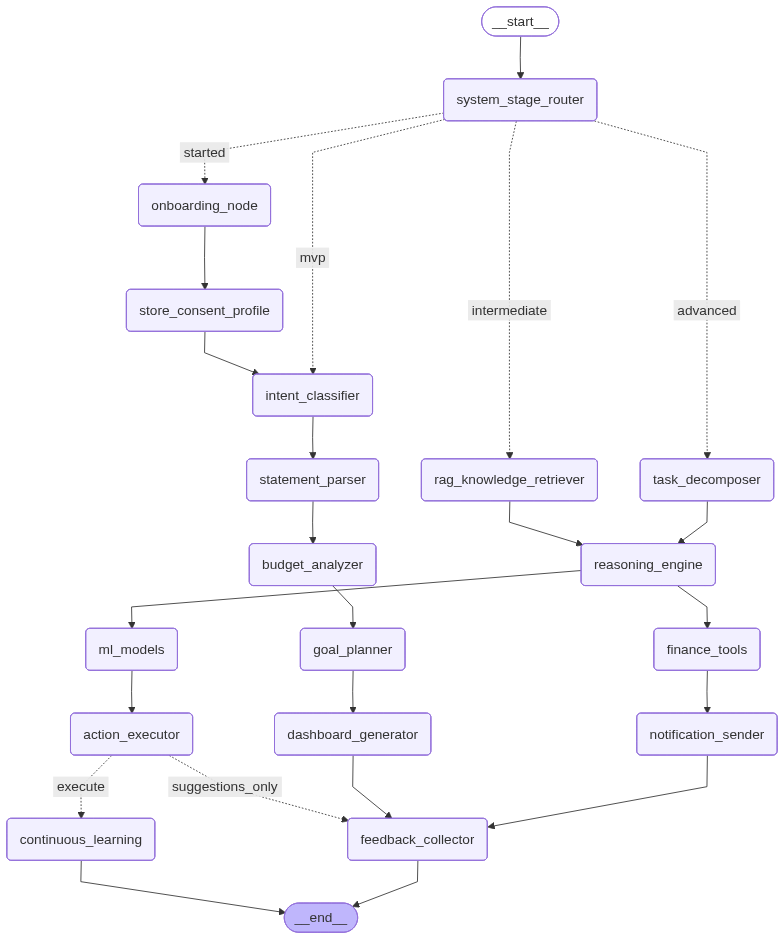

In [10]:
from IPython.display import display, Image

# Display the compiled graph of the workflow
# finance_workflow.workflow is the compiled app from StateGraph.compile()
# We can get a Graphviz/mermaid image via get_graph().draw_mermaid_png()
try:
    graph = getattr(finance_workflow.workflow, "get_graph", None)
    if graph is not None:
        display(Image(finance_workflow.workflow.get_graph().draw_mermaid_png()))
    else:
        # Fallback: if get_graph is not available in this version, inform the user
        print("Compiled workflow does not expose get_graph(). Skipping visualization.")
except Exception as e:
    print("Graph visualization failed:", e)
